# Notebook Iteracion final Modelado

### Objetivo: Crear el modelo final implementando validación cruzada, importancia de vabariables y análisis por zonas


Nota: En esta iteración se usan algunas librerías adicionales a las programadas en funciones.py, como estas no se reutilizarán en ejecuciones posteriores se dejan como locales para este notebook

In [1]:
# Funciones generales
import sys
sys.path.append('../')
# A medida que avanzan las iteraciones se crearan mas funcinoes transversales
from funciones import *

# Tuneo de hiperparámetros
from sklearn.model_selection import ParameterGrid

# Libreria para manejo de balance de datos
import smogn

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Serializacion
import pickle

# Grid Search Validacion cruzada
from sklearn.model_selection import GridSearchCV

# xgboost
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

**Lectura de datos**

Datos resultantes de la iteración 2

In [2]:
import os 
# get current directory
path = os.getcwd()
# parent directory
path = os.path.abspath('../')
data_model = pd.read_csv(path + "/iteracion_2/datos_iteracion_2.csv")
data_model.head()

,precio,zona,barrio_sector,baños_familiares,area_bruta,numero_niveles,parqueaderos,alcobas_familiares,estrato,area_total,...,closet_de_linos,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,dispositivos_automatizacion,alarma,tipo_cocina_freq,tipo_pisos_freq
0,1100000.0,centro,castilla,1.0,95.0,1.0,0.0,3.0,0.0,95.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
1,950000.0,centro,el salvador,1.0,70.0,1.0,0.0,2.0,3.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
2,970000.0,centro,los angeles,1.0,38.0,1.0,0.0,1.0,4.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
3,1400000.0,centro,prado,1.0,50.0,1.0,1.0,2.0,0.0,50.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
4,800000.0,centro,12 de octubre,1.0,92.0,1.0,0.0,3.0,2.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709


**Variables predictoras**

In [3]:
pred_columns = [
    'baños_familiares',
    'area_bruta', 
    'numero_niveles',
    'parqueaderos', 
    'alcobas_familiares', 
    'estrato', 
    'area_total',
    'juegos_infantiles', 
    'balcon', 
    'zona_ropas', 
    'camaras_cctv',
    'cancha_polideportiva', 
    'ascensor', 
    'cancha_squash', 
    'zona_bbq',
    'patio', 
    'unidad_cerrada_conjunto', 
    'zonas_verdes',
    'aire_acondicionado', 
    'jacuzzi', 
    'red_de_Gas', 
    'turco', 
    'porteria_24_7',
    'sauna', 
    'calentador_de_agua', 
    'terraza', 
    'closet_de_linos',
    'biblioteca', 
    'parqueadero_visitantes', 
    'gimnasio', 
    'piscina',
    'salon_social', 
    'dispositivos_automatizacion', 
    'alarma',
    'tipo_cocina_freq', 
    'tipo_pisos_freq'
]

**Variables predictoras**

En la iteración 2 el analisis de distribución y correlaciones dió como resultado la eliminación de las variables:

- columns_disc_corr
- numero_niveles
- zona_ropas
- camaras_cctv
- cancha_polideportiva
- cancha_squash
- zona_bbq
- patio
- aire_acondicionado
- jacuzzi
- red_de_Gas
- terraza
- dispositivos_automatizacion
- alarma
- area_total
- porteria_24_7

Se reutiliza estas variables, sin embargo por criterio del negocio se conservan las siguientes variables dejando su eliminación para un posterior analisis de importancia de variables:

- cancha_polideportiva


In [4]:
columns_disc_corr = [
    "numero_niveles",
    "zona_ropas",
    "camaras_cctv",
    "cancha_squash",
    "zona_bbq",
    "patio",
    "aire_acondicionado",
    "jacuzzi",
    "red_de_Gas",
    "terraza",
    "dispositivos_automatizacion",
    "alarma",
    "area_total",
    "porteria_24_7"
]

**Estandarización**

In [5]:
X = data_model[pred_columns]
Y = data_model['precio']

In [6]:
X_est = estandarizar(X)

**Clustering**

Se procede con la ejecucion del algoritmo de kmeans entre las variables __precio__ y __area_bruta__, esta última por ser la mas relevante en la ejecución del modelo línea base y el análisis de correlaciones

In [7]:
X_est['precio'] = Y.values

In [8]:
x_cluster = X_est[['estrato', 'area_bruta']].values
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans_labels = kmeans.fit_predict(x_cluster)
    sample_silhouette_values = silhouette_samples(x_cluster, kmeans_labels)
    print("silhouette_score k = {} : {}".format(k , sample_silhouette_values.mean()))

silhouette_score k = 2 : 0.5584902744604046
silhouette_score k = 3 : 0.6143361136796931
silhouette_score k = 4 : 0.5603650463061598
silhouette_score k = 5 : 0.5731226948655109


Segun el cálculo del coeficiente de siluetas se obtiene un mejor resultado para 3 clusters, se selecciona este valor para hacer la división de los datos

Entrenamiento y calculo de las etiquetas de los clusters

In [9]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans_labels = kmeans.fit_predict(x_cluster)

Se añade la etiqueta cluster como nueva variable de la base de entrenamiento

In [10]:
X_est['cluster'] = kmeans_labels

Serialización del modelo clustering

In [11]:
with open('kmeans_arriendos.pkl', 'wb') as pickle_file:
    pickle.dump(kmeans, pickle_file) 

**Modelo**

Se ejecuta un proceso de entrenamiento incluyendo el método de validación cruzada para obtener el modelo final

Se eliminan las variables de la base de modelado dado los anteriores análisis

In [12]:
X_cluster_0 = X_est[X_est['cluster'] == 0]
# X_cluster_1 = X_est[X_est['cluster'].isin([1])]
# X_cluster_1 = X_cluster_1[(X_cluster_1['precio'] >= 3800000) & (X_cluster_1['precio'] <= 6900000) ]
# X_cluster_2 = X_est[X_est['cluster'].isin([2])]
# X_cluster_2 = X_cluster_2[(X_cluster_2['precio'] >= 2000000) & (X_cluster_2['precio'] <= 6900000)]
# X_concat = pd.concat([X_cluster_0, X_cluster_1, X_cluster_2])

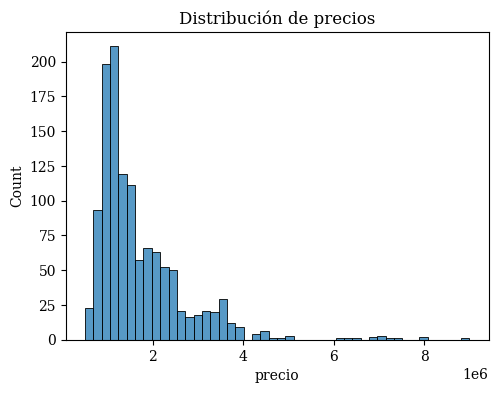

In [13]:
graficar_distribucion_histograma( X_cluster_0, 'precio', 'Distribución de precios')

In [14]:
x_model = X_cluster_0.drop(columns = columns_disc_corr)
x_model = x_model.drop(columns= ['precio', 'cluster'])
y_model = X_cluster_0['precio']
imprimir_dimensiones(x_model)

Numero de muestras: 1217, Número de columnas: 22


**Dvisión de los datos:** Entrenamiento 75%, Test 25%

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, test_size = 0.25, train_size = 0.75, random_state = 17)
print("Tamaño de los Datos de Entrenamiento = ", x_train.shape)
print("Tamaño de los Datos de Validación = ", x_test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", y_train.shape)
print("Tamaño del Vector de Clases de Prueba = ", y_test.shape)

Tamaño de los Datos de Entrenamiento =  (912, 22)
Tamaño de los Datos de Validación =  (305, 22)
Tamaño del Vector de Clases de Entrenamiento =  (912,)
Tamaño del Vector de Clases de Prueba =  (305,)


**XGBOOST cv**

Entrenamiento del modelo por medio de validación cruzada

In [38]:
param_grid_xgb = {
    'n_estimators' : [100, 120],
    'max_depth' : [9, 10, 11],
    'learning_rate' : [.03],
    'objective' : ['reg:squarederror'],
    'subsample' : [0.2, 0.2],
    'eta' : [.01,.05, .07],
}

grid = GridSearchCV(
        estimator  = xgb.XGBRegressor(random_state=123),
        param_grid = param_grid_xgb,
        scoring    = 'r2',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=x_train, y= y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05, 0.07], 'learning_rate': [0.03],
                         'max_depth': [9, 10, 11], 'n_estimators': [100, 120],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.2, 0.2]},
             return_train_score=True, scoring='r2')

Obtencion de los resultados de las diferentes combinaciones de hiperparámetros

In [39]:
resultados_cv = pd.DataFrame(grid.cv_results_)
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_eta,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
15,0.05,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
2,0.01,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
3,0.01,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
27,0.07,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
26,0.07,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
14,0.05,0.03,9,120,reg:squarederror,0.2,0.606173,0.031884,0.785987,0.006268
35,0.07,0.03,11,120,reg:squarederror,0.2,0.605981,0.031878,0.788386,0.006718
34,0.07,0.03,11,120,reg:squarederror,0.2,0.605981,0.031878,0.788386,0.006718
23,0.05,0.03,11,120,reg:squarederror,0.2,0.605981,0.031878,0.788386,0.006718
10,0.01,0.03,11,120,reg:squarederror,0.2,0.605981,0.031878,0.788386,0.006718


In [40]:
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .to_csv("xgoost_iteraciones_cv.csv", index=False)

Mejor combinación de hiperparámetros

In [41]:
grid.best_params_

{'eta': 0.01,
 'learning_rate': 0.03,
 'max_depth': 9,
 'n_estimators': 120,
 'objective': 'reg:squarederror',
 'subsample': 0.2}

Mejor modelo

In [42]:
xgb_final = grid.best_estimator_

Métricas del mejor modelo

In [43]:
resultados = {'R2_train': [],
               'R2_test': [],
               'RMSE_train': [],
               'RMSE_test': [],
               'MAPE_train': [],
               'MAPE_test': [],}
resultados['R2_train'].append(r2_score(y_true=y_train, y_pred=xgb_final.predict(x_train)))
resultados['R2_test'].append(r2_score(y_true=y_test, y_pred=xgb_final.predict(x_test)))
resultados['RMSE_train'].append(mean_squared_error(y_true=y_train, y_pred=xgb_final.predict(x_train), squared=False))
resultados['RMSE_test'].append(mean_squared_error(y_true=y_test, y_pred=xgb_final.predict(x_test), squared=False))
resultados['MAPE_train'].append(mean_absolute_percentage_error(y_true=y_train, y_pred  = xgb_final.predict(x_train)))
resultados['MAPE_test'].append(mean_absolute_percentage_error(y_true=y_test, y_pred  = xgb_final.predict(x_test)))
pd.DataFrame(resultados)

,R2_train,R2_test,RMSE_train,RMSE_test,MAPE_train,MAPE_test
0,0.785295,0.731046,476610.204546,490008.012375,0.141506,0.156759


Cálculo de importancia de variables

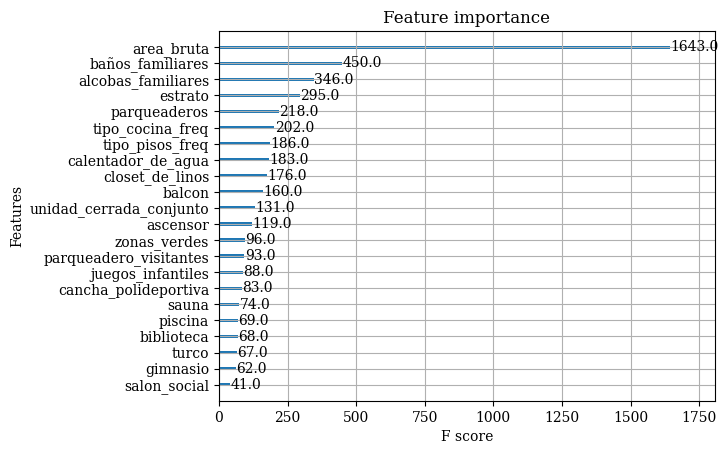

<Figure size 1600x1600 with 0 Axes>

In [44]:
xgb.plot_importance(xgb_final)
plt.figure(figsize = (16, 16))
plt.show()

Análisis de zonas

Al encontrar el mejor modelo se procede a evaluar su efectividad por zonas de manera que se recomiende al negocio dónde implementar el modelo final

In [49]:
columns_test_zones = list(x_train.columns)
columns_test_zones.extend(['zona', 'precio'])

In [51]:
X_est['zona'] = data_model['zona']

In [52]:
data_zonas = X_est[columns_test_zones]

Analísis de efectividad del modelo por la variable zona

In [53]:
data_centro = data_zonas[data_zonas['zona'] == 'centro']
data_poblado = data_zonas[data_zonas['zona'] == 'poblado']
data_laureles = data_zonas[data_zonas['zona'] == 'laureles']
data_belen = data_zonas[data_zonas['zona'] == 'belen']
data_sa_prado = data_zonas[data_zonas['zona'] == 'sa_prado']

Para cumplir con los requisitos del negocio se evalúa la efectividad del modelo por la división de zonas obtenida por el proceso de web scraping, donde en ninguna de estas se logra un MAPE <= 0.15, por tanto, la recomendación al negocio debe proceder de otra estrategia de implementación

Al ejecutar la iteración 6 se observa que para los datos del cluster 0 se obtiene un MAPE = 0.15, esto da a pensar que las carácteristicas de los inmuebles pueden ser el factor determinante para que el negocio filtre sobre que inmuebles se debe ejecutar el modelo, por ejemplo, si se evalúa los inmuebles con la siguiente combinación de variables:

In [58]:
data_test = data_zonas[(data_zonas['area_bruta'] >= 0.2) & (data_zonas['estrato'] == 0.5)]
print("Cantidad de muestras: ", len(data_test))
print('MAPE: ', mean_absolute_percentage_error(y_true=data_test['precio'].values, y_pred  = xgb_final.predict(data_test[x_train.columns])))

Cantidad de muestras:  30
MAPE:  0.12519476567026763


Se observa un MAPE dentro de los rangos del negocio, por tanto, para el modelo obtenido, una de las recomendaciones al negocio es encontrar un patrón en las variables que muestre sobre que tipo de viviendas se debe filtrar para hacer la implementación del modelo.

En resumen, este proceso establecerá una condición para el uso del modelo que puede seguir una premisa como:
- Este modelo es funcional solo para inmuebles con un área bruta mayor a N mts
- Este modelo es funcional solo para inmuebles con un área bruta mayor a N mts y M baños
- Este modelo es funcional solo para inmuebles con un área bruta mayor a N mts y estrato K


Este proceso se deja para un trabajo futuro del proyecto

Serialización del modelo final

In [59]:
with open('xgboost_arriendos.pkl', 'wb') as pickle_file:
    pickle.dump(xgb_final, pickle_file) 

**Conclusiones:**

- La predicción de precios de arriendos en la ciudad de Medellín se soluciona mediante la creación de un proceso de scraping, la implementación de un algoritmo kmeans como parte del proceso de feature engineering y el entrenamiento de un modelo xgboost
- Se obtiene un modelo xgboost con las caracteristicas deseadas por el negocio (MAPE <= 0.15)
- La implementación del modelo para cumplir al 100% los requisitos del negocio se plantea para un trabajo futuro donde se recomienda encontrar un patron de los datos que permita filtrar, en base a las carateríticas de las viviendas, el uso efectivo de este
- La variable __area_bruta__, predomina en importancia en este modelo, lo que indica la alta influencia que tiene el tamaño de una vivienda en su precio. se nota también variables como __tipo_pisos_freq__ son bastante influyentes, siendo esta resultado del proceso de tratamiento de la información se evidencia la importancia que tuvo este proceso.
- No se evidencia variables con importancia 0 o cercano a este valor en ninguna de las variables, por tanto, no se ejecuta eliminación de variables por este criterio